In [1]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from typing import Optional, Union, List, Tuple
import numpy as np
import torch

In [2]:
class DataTransformer:
    def __init__(self, dataframe, use_gpu=True):
        self.dataframe = dataframe
        self.use_gpu = use_gpu and torch.cuda.is_available()

    def normalize_data(self, columns, methods):
        """
        Normaliza os dados nas colunas especificadas usando os métodos escolhidos.

        :param columns: Lista de nomes das colunas para normalizar.
        :param methods: Lista de nomes de métodos de normalização ("standardize", "min_max", "z_score").

        :return: DataFrame com os dados normalizados.
        """
        normalized_df = self.dataframe.copy()
        normalizers = {
            "standardize": self._standardize,
            "min_max": self._min_max,
            "z_score": self._z_score,
        }

        for column in columns:
            for method in methods:
                normalized_df[column] = normalizers[method](normalized_df[column])

        return normalized_df

    def _standardize(self, data):
        """
        Aplica padronização (z-score) aos dados.

        :param data: Coluna de dados a ser padronizada.
        """
        return (data - data.mean()) / data.std()

    def _min_max(self, data):
        """
        Aplica normalização min-max aos dados.

        :param data: Coluna de dados a ser normalizada.
        """
        return (data - data.min()) / (data.max() - data.min())

    def _z_score(self, data):
        """
        Aplica normalização z-score aos dados.

        :param data: Coluna de dados a ser normalizada.
        """
        return (data - data.mean()) / data.std()

    def _get_explained_variance(self, n_components):
        """
        Obtém a explicação de variância para o método PCA.

        :param n_components: Número de componentes principais a serem mantidos.
        """
        # Remover colunas não numéricas antes de aplicar o PCA
        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        dataframe_numeric = self.dataframe[numeric_columns]

        pca = PCA(n_components=n_components)
        pca.fit(dataframe_numeric)
        return pca.explained_variance_ratio_
    
    def _pca_reduction(self, n_components, use_gpu=False):
        """
        Reduz a dimensionalidade usando Análise de Componentes Principais (PCA).

        :param n_components: Número de componentes principais a serem mantidos.
        :param use_gpu: Se True, usa GPU (se disponível) para acelerar o cálculo.
        """
        # Remover colunas não numéricas antes de aplicar o PCA
        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        dataframe_numeric = self.dataframe[numeric_columns]

        if use_gpu:
            # Se use_gpu for True, tenta utilizar a GPU para acelerar o PCA
            try:
                # Converte o DataFrame para um tensor PyTorch na GPU
                data_tensor = torch.tensor(dataframe_numeric.values, dtype=torch.float32, device="cuda")
                
                # Realiza o PCA no tensor GPU
                pca = PCA(n_components=n_components)
                reduced_data = pca.fit_transform(data_tensor.cpu().numpy())
            except Exception as e:
                print(f"A GPU não está disponível ou ocorreu um erro ao utilizá-la: {e}")
                # Se houver algum erro, utiliza a CPU
                pca = PCA(n_components=n_components)
                reduced_data = pca.fit_transform(dataframe_numeric)
        else:
            # Utiliza a CPU para cálculos
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(dataframe_numeric)

        return reduced_data, pca.explained_variance_ratio_

    def _lda_reduction(self, n_components, labels):
        """
        Reduz a dimensionalidade usando Análise Discriminante Linear (LDA).

        :param n_components: Número de componentes principais a serem mantidos.
        :param labels: Rótulos de classe.
        """
        # Remover colunas não numéricas antes de aplicar o PCA
        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        dataframe_numeric = self.dataframe[numeric_columns]

        return LDA(n_components=n_components).fit_transform(dataframe_numeric, labels)
    
    def _nnd_reduction(self, n_components, use_gpu=False):
        """
        Reduz a dimensionalidade usando t-SNE.

        :param n_components: Número de componentes principais a serem mantidos.
        :param use_gpu: Se True, usa GPU (se disponível) para acelerar o cálculo.
        """
        # Selecione colunas numéricas antes de aplicar o t-SNE
        numeric_columns = self.dataframe.select_dtypes(include=['number']).columns
        dataframe_numeric = self.dataframe[numeric_columns]

        tsne = TSNE(n_components=n_components)

        if use_gpu:
            try:
                # Verifica se a GPU está disponível
                device = torch.device("cuda")
                tsne = tsne.to(device)

                # Converte os dados para tensor GPU
                data_tensor = torch.tensor(dataframe_numeric.values, dtype=torch.float32, device=device)
                
                # Realiza o t-SNE no tensor GPU
                reduced_data = tsne.fit_transform(data_tensor.cpu().numpy())

                # Imprime a mensagem indicando o uso da GPU
                print("Usando GPU para o cálculo do t-SNE.")
            except:
                # Se houver um erro ao tentar usar a GPU, fallback para CPU
                print("GPU não disponível. Usando CPU para o cálculo do t-SNE.")
                reduced_data = tsne.fit_transform(dataframe_numeric)
        else:
            # Utiliza a CPU para cálculos
            print("Usando CPU para o cálculo do t-SNE.")
            reduced_data = tsne.fit_transform(dataframe_numeric)

        return reduced_data

    def reduce_dimensionality(self, n_components: int, method: str, labels: Optional[List[str]] = None) -> Tuple[np.ndarray, Union[np.ndarray, None]]:
        """
        Reduz a dimensionalidade do DataFrame usando o método especificado.

        :param n_components: Número de componentes principais a serem mantidos.
        :param method: Nome do método de redução de dimensionalidade ("pca", "lda", "nnd").
        :param labels: Rótulos de classe necessários para o método "lda".

        :return: DataFrame com dimensionalidade reduzida e explicação de variância (se aplicável).
        """
        if method not in ("pca", "lda", "nnd"):
            raise ValueError(f"Método inválido: {method}")

        # Verificar se a GPU está disponível e se o método permite uso de GPU
        use_gpu = self.use_gpu and method in ("pca", "nnd")

        if method == "pca":
            reduced_data, explained_variance = self._pca_reduction(n_components, use_gpu)
        elif method == "lda":
            if labels is None:
                raise ValueError("Rótulos de classe (labels) são necessários para o método 'lda'.")
            
            # Convertendo rótulos para representação numérica
            encoded_labels = LabelEncoder().fit_transform(labels)
            
            reduced_data = self._lda_reduction(n_components, encoded_labels)
            explained_variance = None  # Explained variance não se aplica ao LDA
        elif method == "nnd":
            reduced_data = self._nnd_reduction(n_components, use_gpu)
            explained_variance = None  # Explained variance não se aplica ao t-SNE

        return reduced_data, explained_variance

    def save_to_csv(self, filename):
        """
        Salva o DataFrame em um arquivo CSV.
        
        :param nome_arquivo: Nome do arquivo CSV de saída.
        """
        self.dataframe.to_csv(filename, index = False)
        
    def getting_modified_dataframe(self):
        """
        Retorna o DataFrame modificado após todas as operações de limpeza.
        """
        return self.dataframe

In [3]:
# Carregar o arquivo CSV em um DataFrame
caminho_arquivo_csv = '../data/processed/houses_to_rent_v2_processed.csv'
dataframe = pd.read_csv(caminho_arquivo_csv, sep=",", encoding="UTF-8")

# Criar uma instância da classe DataPreprocessor com o DataFrame
processador = DataTransformer(dataframe)

# Realizar operações de normalização nas colunas especificadas
colunas_normalizar = ["AREA", "ROOMS",
                      "BATHROOM", "PARKING_SPACES", "HOA_(R$)",
                      "PROPERTY_TAX_(R$)", "FIRE_INSURANCE_(R$)"
                      ]
metodos_normalizacao = ['standardize', 'min_max', 'z_score']
dataframe_normalizado = processador.normalize_data(colunas_normalizar, metodos_normalizacao)

# Converter a coluna FLOOR para o tipo float
dataframe['FLOOR'] = dataframe['FLOOR'].astype('float')

# Reduzir a dimensionalidade usando PCA
num_componentes_pca = 3
dataframe_reduzido_pca, explained_variance_pca = processador.reduce_dimensionality(num_componentes_pca, 'pca')

# Remova espaços em branco extras antes de aplicar o LabelEncoder
rótulos_de_classe = dataframe_normalizado['CITY'].str.strip()

# Converta os rótulos de classe para números
encoded_labels = LabelEncoder().fit_transform(rótulos_de_classe)

# Reduzir a dimensionalidade usando LDA
num_componentes_lda = 2
dataframe_reduzido_lda, _ = processador.reduce_dimensionality(num_componentes_lda, 'lda', labels=encoded_labels)


# Reduzir a dimensionalidade usando TSNE
num_componentes_tsne = 2
dataframe_reduzido_tsne, _ = processador.reduce_dimensionality(num_componentes_tsne, 'nnd')

# Salvar o DataFrame limpo e transformado como um novo arquivo CSV
nome_arquivo_saida = '../data/transformed/houses_to_rent_v2_transformed.csv'
processador.save_to_csv(nome_arquivo_saida)

Usando CPU para o cálculo do t-SNE.


In [122]:
dataframe_normalizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7963 entries, 0 to 7962
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CITY                 7963 non-null   object 
 1   AREA                 7963 non-null   float64
 2   ROOMS                7963 non-null   float64
 3   BATHROOM             7963 non-null   float64
 4   PARKING_SPACES       7963 non-null   float64
 5   FLOOR                7963 non-null   int64  
 6   ANIMAL               7963 non-null   int64  
 7   FURNITURE            7963 non-null   int64  
 8   HOA_(R$)             7963 non-null   float64
 9   RENT_AMOUNT_(R$)     7963 non-null   int64  
 10  PROPERTY_TAX_(R$)    7963 non-null   float64
 11  FIRE_INSURANCE_(R$)  7963 non-null   float64
 12  TOTAL_(R$)           7963 non-null   int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 808.9+ KB


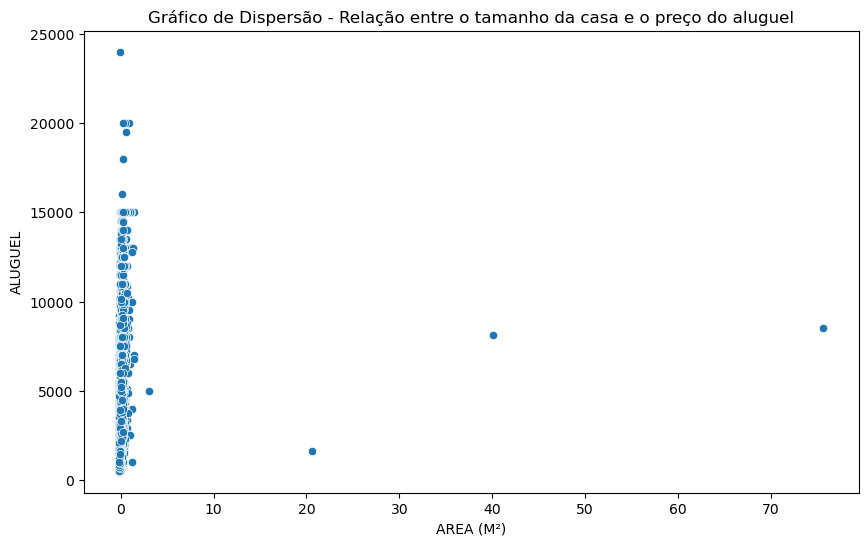

In [123]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Procura o diretório raiz do projeto com o sys.path
sys.path.append(str(Path.cwd().parent))

from src.visualization.visualize import DataVisualization

data_visualization = DataVisualization()

# Exemplos de chamadas para os plots
data_visualization.plotar_dispersao(dataframe_normalizado,
                                    'AREA',
                                    'RENT_AMOUNT_(R$)',
                                    "AREA (M²)",
                                    "ALUGUEL",
                                    "Gráfico de Dispersão - Relação entre o tamanho da casa e o preço do aluguel"
                                    )


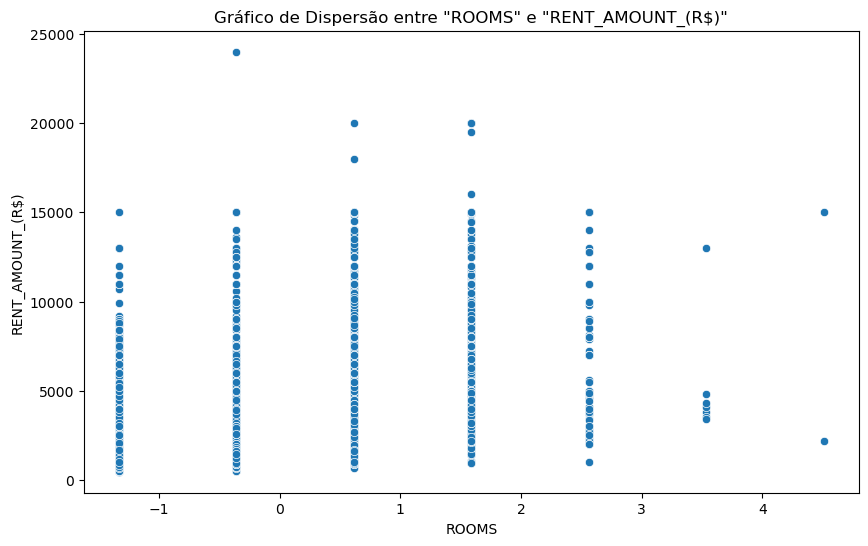

In [124]:
data_visualization.plotar_dispersao(dataframe_normalizado, 'ROOMS', 'RENT_AMOUNT_(R$)')


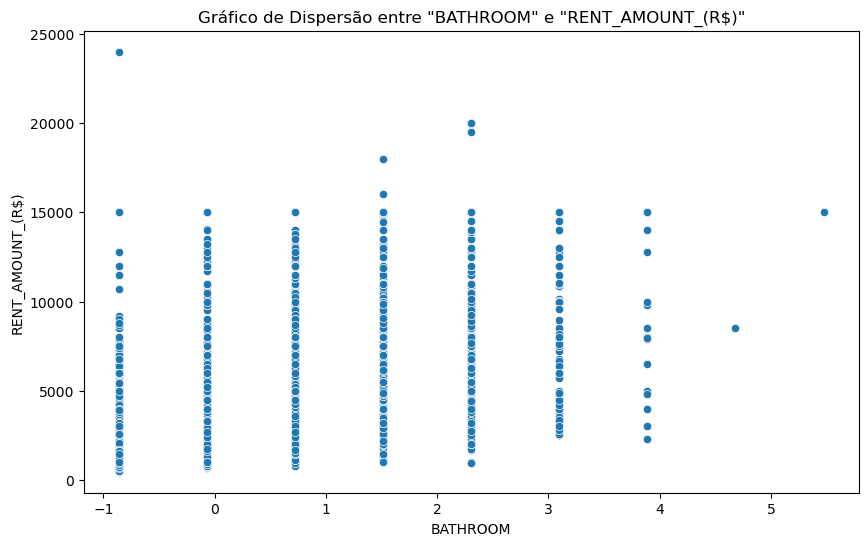

In [125]:
data_visualization.plotar_dispersao(dataframe_normalizado, 'BATHROOM', 'RENT_AMOUNT_(R$)')


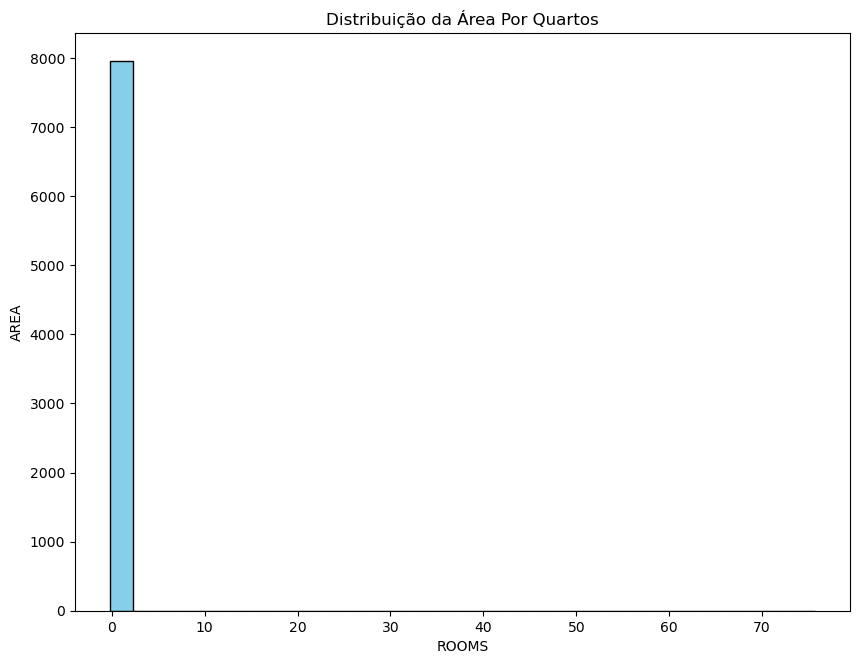

In [126]:
data_visualization.plotar_histogramas(dataframe_normalizado,
                                      'AREA',
                                      'ROOMS',
                                      'AREA',
                                      'Distribuição da Área Por Quartos'
                                      )

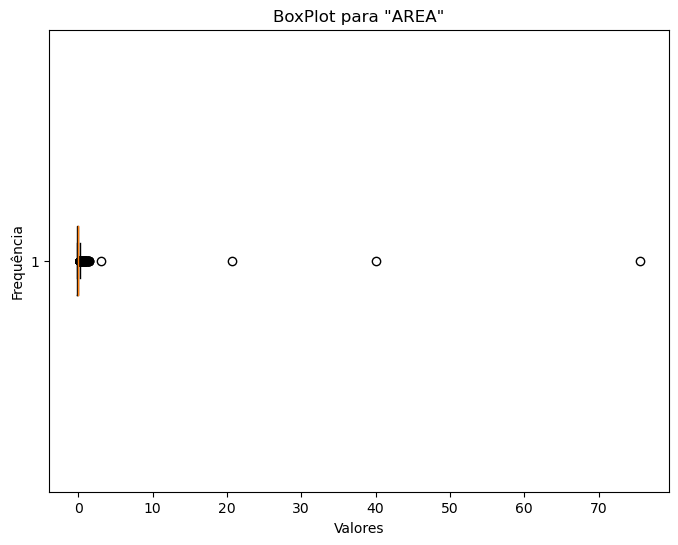

In [127]:
data_visualization.boxplot_plot(dataframe_normalizado,
                                'AREA',
                                )

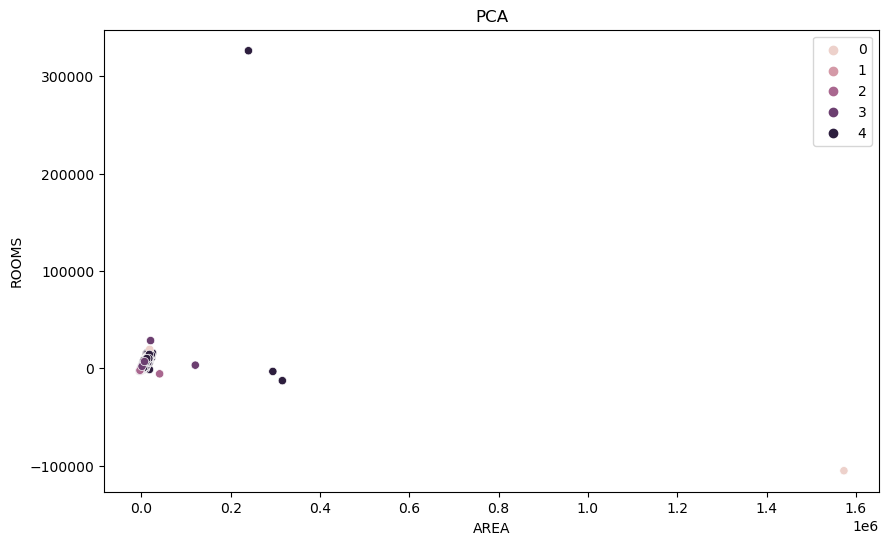

In [128]:
data_visualization.plotar_scatterplot_com_cores_codificadas_por_classe(
    dataframe=pd.DataFrame({'Componente Principal 1': dataframe_reduzido_pca[:, 0], 'Componente Principal 2': dataframe_reduzido_pca[:, 1]}),
    coluna_x='Componente Principal 1',
    coluna_y='Componente Principal 2',
    xlabel='AREA',
    ylabel='ROOMS',
    titulo='PCA',
    encoded_labels=encoded_labels
)


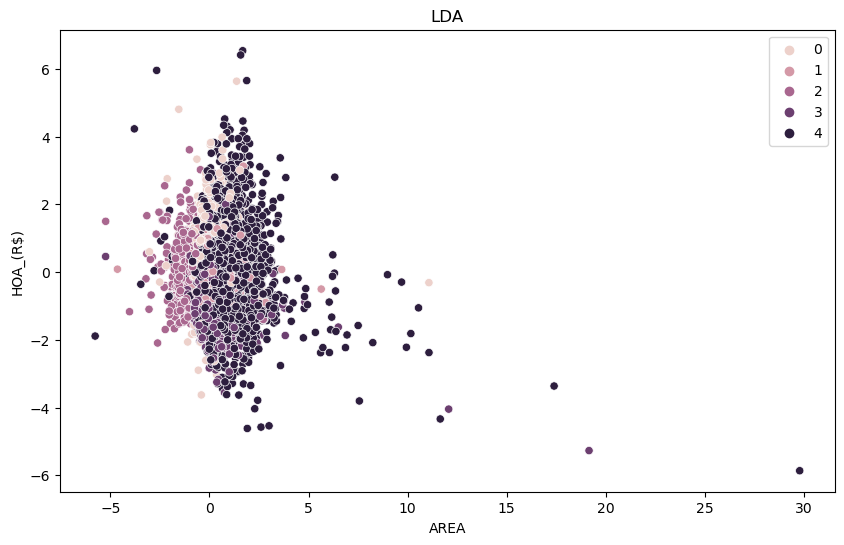

In [129]:
data_visualization.plotar_scatterplot_com_cores_codificadas_por_classe(
    dataframe=pd.DataFrame({'Componente Principal 1': dataframe_reduzido_lda[:, 0], 'Componente Principal 2': dataframe_reduzido_lda[:, 1]}),
    coluna_x='Componente Principal 1',
    coluna_y='Componente Principal 2',
    xlabel='AREA',
    ylabel='HOA_(R$)',
    titulo='LDA',
    encoded_labels=encoded_labels
)


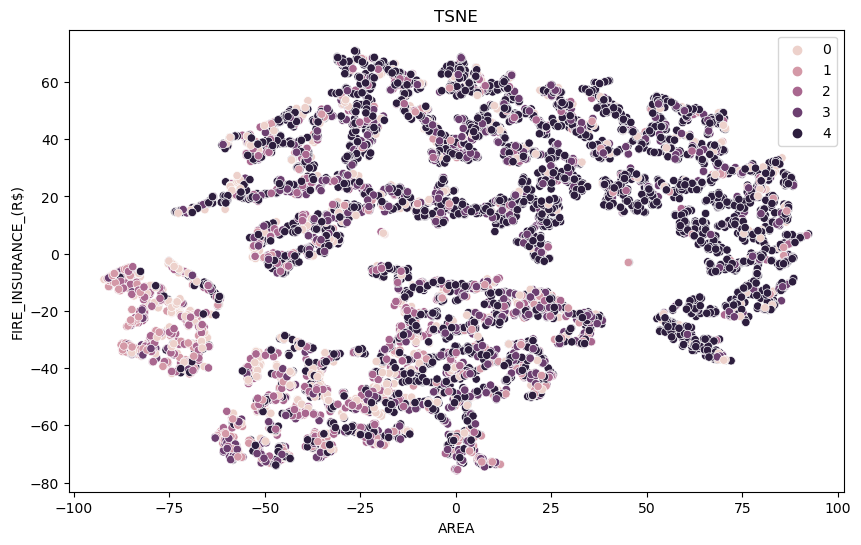

In [130]:
data_visualization.plotar_scatterplot_com_cores_codificadas_por_classe(
    dataframe=pd.DataFrame({'Componente Principal 1': dataframe_reduzido_tsne[:, 0], 'Componente Principal 2': dataframe_reduzido_tsne[:, 1]}),
    coluna_x='Componente Principal 1',
    coluna_y='Componente Principal 2',
    xlabel='AREA',
    ylabel='FIRE_INSURANCE_(R$)',
    titulo='TSNE',
    encoded_labels=encoded_labels
)


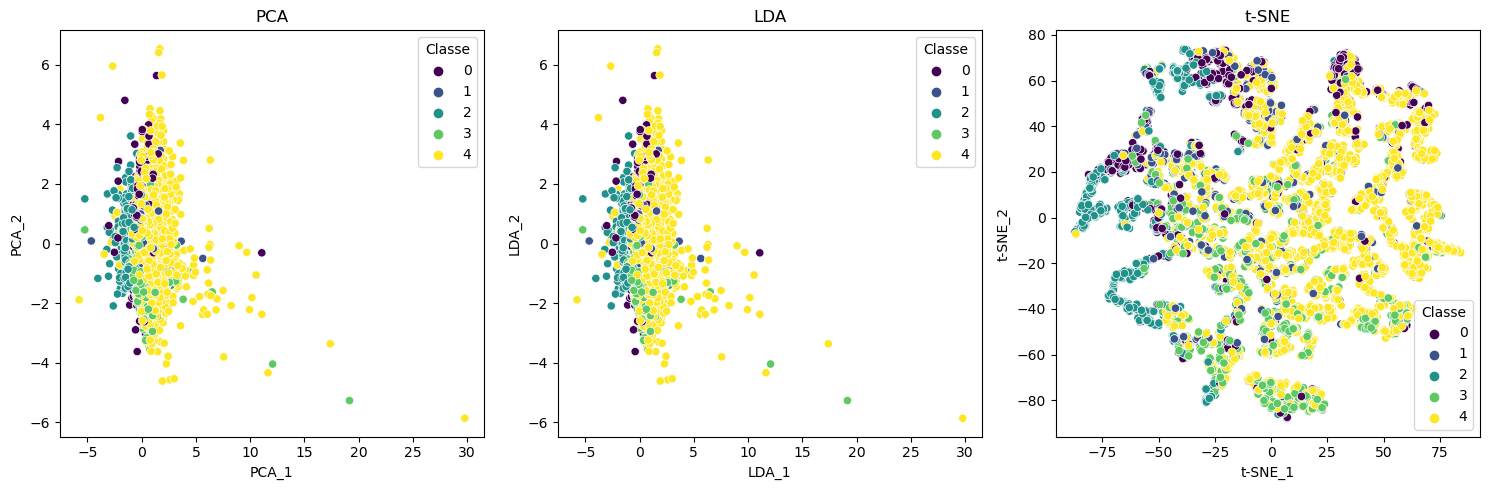

In [131]:
# Chame o método comparar_dimensionalidade
data_visualization.comparar_dimensionalidade(dataframe_reduzido_lda, encoded_labels)